In [1]:
import os
import cv2
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, fbeta_score
from keras import optimizers
from keras import backend as K
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/imet-2019-fgvc6/train.csv')
labels = pd.read_csv('../input/imet-2019-fgvc6/labels.csv')
test = pd.read_csv('../input/imet-2019-fgvc6/sample_submission.csv')

train["attribute_ids"] = train["attribute_ids"].apply(lambda x:x.split(" "))
train["id"] = train["id"].apply(lambda x: x + ".png")
test["id"] = test["id"].apply(lambda x: x + ".png")

print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
print('Number of labels: ', labels.shape[0])
display(train.head())
display(labels.head())

Number of train samples:  109237
Number of test samples:  7443
Number of labels:  1103


,id,attribute_ids
0,1000483014d91860.png,"[147, 616, 813]"
1,1000fe2e667721fe.png,"[51, 616, 734, 813]"
2,1001614cb89646ee.png,[776]
3,10041eb49b297c08.png,"[51, 671, 698, 813, 1092]"
4,100501c227f8beea.png,"[13, 404, 492, 903, 1093]"


,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


### Bottleneck features using VGG16

In [3]:
# Model parameters
BATCH_SIZE = 64
EPOCHS = 200
LEARNING_RATE = 0.1
HEIGHT = 64
WIDTH = 64
CANAL = 3
N_CLASSES = labels.shape[0]
classes = list(map(str, range(N_CLASSES)))

In [4]:
def f2_score_thr(threshold=0.5):
    def f2_score(y_true, y_pred):
        beta = 2
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), K.floatx())

        true_positives = K.sum(K.clip(y_true * y_pred, 0, 1), axis=1)
        predicted_positives = K.sum(K.clip(y_pred, 0, 1), axis=1)
        possible_positives = K.sum(K.clip(y_true, 0, 1), axis=1)

        precision = true_positives / (predicted_positives + K.epsilon())
        recall = true_positives / (possible_positives + K.epsilon())

        return K.mean(((1+beta**2)*precision*recall) / ((beta**2)*precision+recall+K.epsilon()))
    return f2_score

def step_decay(epoch):
    initial_lrate = LEARNING_RATE
    drop = 0.5
    epochs_drop = 10
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    return lrate

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/imet-2019-fgvc6/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode=None,
    target_size=(HEIGHT, WIDTH))

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/imet-2019-fgvc6/test",    
        x_col="id",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 109237 images.
Found 7443 images.


In [6]:
# Build the VGG16 network
model_vgg = VGG16(weights=None, include_top=False)
model_vgg.load_weights('../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size

train_data = model_vgg.predict_generator(train_generator, STEP_SIZE_TRAIN)

train_labels = []
for label in train['attribute_ids'][:train_data.shape[0]].values:
    zeros = np.zeros(N_CLASSES)
    for label_i in label:
        zeros[int(label_i)] = 1
    train_labels.append(zeros)
    
train_labels = np.asarray(train_labels)

X_train, X_val, Y_train, Y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=0)

Instructions for updating:
Colocations handled automatically by placer.


### Model

In [7]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(N_CLASSES, activation="softmax"))

optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.8, decay=0.0, nesterov=False)
thresholds = [0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
metrics = ["accuracy", "categorical_accuracy", f2_score_thr(0.15), f2_score_thr(0.2), 
           f2_score_thr(0.25), f2_score_thr(0.3), f2_score_thr(0.4), f2_score_thr(0.5)]
lrate = LearningRateScheduler(step_decay)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
callbacks = [lrate, es]
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metrics)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
history = model.fit(x=X_train, y=Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks,
                    verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 87347 samples, validate on 21837 samples
Epoch 1/200
 - 9s - loss: 17.5617 - acc: 0.0184 - categorical_accuracy: 0.0184 - f2_score: 0.0012 - f2_score_1: 7.7623e-04 - f2_score_2: 5.6308e-04 - f2_score_3: 4.6907e-04 - f2_score_4: 3.5394e-04 - f2_score_5: 2.6820e-04 - val_loss: 16.9751 - val_acc: 0.0114 - val_categorical_accuracy: 0.0114 - val_f2_score: 0.0000e+00 - val_f2_score_1: 0.0000e+00 - val_f2_score_2: 0.0000e+00 - val_f2_score_3: 0.0000e+00 - val_f2_score_4: 0.0000e+00 - val_f2_score_5: 0.0000e+00
Epoch 2/200
 - 8s - loss: 16.8835 - acc: 0.0148 - categorical_accuracy: 0.0148 - f2_score: 3.7260e-04 - f2_score_1: 1.8193e-04 - f2_score_2: 9.7875e-05 - f2_score_3: 5.3489e-05 - f2_score_4: 3.4622e-05 - f2_score_5: 2.2448e-05 - val_loss: 16.9057 - val_acc: 0.0112 - val_categorical_accuracy: 0.0112 - val_f2_score: 0.0000e+00 - val_f2_score_1: 0.0000e+00 - val_f2_score_2: 0.0000e+00 - val_f2_score_3: 0.0000e+00 - val_f2_score_4: 0.

### Model graph loss

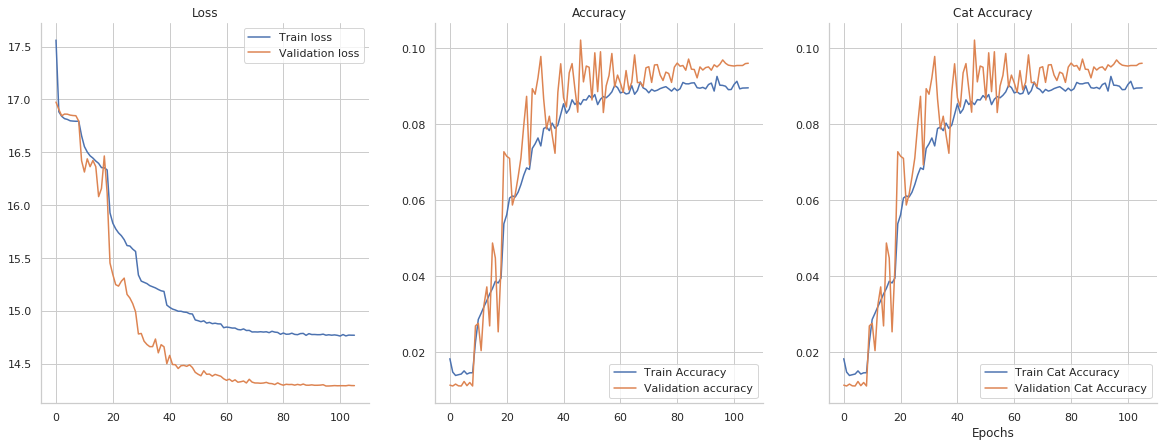

In [9]:
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(20,7))


ax1.plot(history.history['loss'], label='Train loss')
ax1.plot(history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history.history['acc'], label='Train Accuracy')
ax2.plot(history.history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

ax3.plot(history.history['categorical_accuracy'], label='Train Cat Accuracy')
ax3.plot(history.history['val_categorical_accuracy'], label='Validation Cat Accuracy')
ax3.legend(loc='best')
ax3.set_title('Cat Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

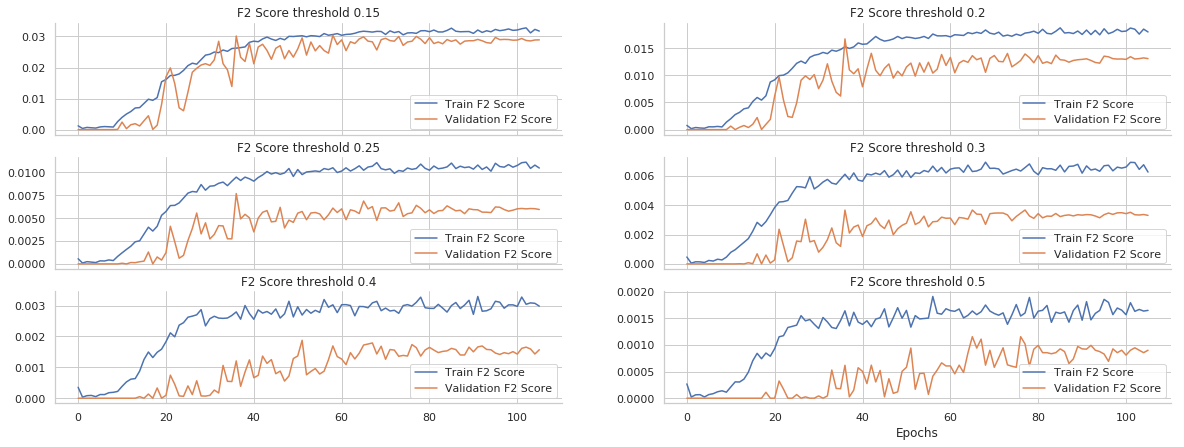

In [10]:
fig, axes = plt.subplots(3, 2, sharex='col', figsize=(20,7))

axes[0][0].plot(history.history['f2_score'], label='Train F2 Score')
axes[0][0].plot(history.history['val_f2_score'], label='Validation F2 Score')
axes[0][0].legend(loc='best')
axes[0][0].set_title('F2 Score threshold 0.15')

axes[0][1].plot(history.history['f2_score_1'], label='Train F2 Score')
axes[0][1].plot(history.history['val_f2_score_1'], label='Validation F2 Score')
axes[0][1].legend(loc='best')
axes[0][1].set_title('F2 Score threshold 0.2')

axes[1][0].plot(history.history['f2_score_2'], label='Train F2 Score')
axes[1][0].plot(history.history['val_f2_score_2'], label='Validation F2 Score')
axes[1][0].legend(loc='best')
axes[1][0].set_title('F2 Score threshold 0.25')

axes[1][1].plot(history.history['f2_score_3'], label='Train F2 Score')
axes[1][1].plot(history.history['val_f2_score_3'], label='Validation F2 Score')
axes[1][1].legend(loc='best')
axes[1][1].set_title('F2 Score threshold 0.3')

axes[2][0].plot(history.history['f2_score_4'], label='Train F2 Score')
axes[2][0].plot(history.history['val_f2_score_4'], label='Validation F2 Score')
axes[2][0].legend(loc='best')
axes[2][0].set_title('F2 Score threshold 0.4')

axes[2][1].plot(history.history['f2_score_5'], label='Train F2 Score')
axes[2][1].plot(history.history['val_f2_score_5'], label='Validation F2 Score')
axes[2][1].legend(loc='best')
axes[2][1].set_title('F2 Score threshold 0.5')

plt.xlabel('Epochs')
sns.despine()
plt.show()

### Find best threshold value

In [11]:
best_thr = 0
best_thr_val = history.history['val_f2_score'][-1]
for i in range(1, len(metrics)-2):
    if best_thr_val < history.history['val_f2_score_%s' % i][-1]:
        best_thr_val = history.history['val_f2_score_%s' % i][-1]
        best_thr = i

threshold = thresholds[best_thr]
print('Best threshold is: %s' % threshold)

Best threshold is: 0.15


### Apply model to test set and output predictions

In [12]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
bottleneck_preds = model_vgg.predict_generator(test_generator, steps=STEP_SIZE_TEST)
preds = model.predict(bottleneck_preds)

In [13]:
predictions = []
for pred_ar in preds:
    valid = ''
    for idx, pred in enumerate(pred_ar):
        if pred > threshold:
            if len(valid) == 0:
                valid += str(idx)
            else:
                valid += (' %s' % idx)
    if len(valid) == 0:
        valid = np.argmax(pred_ar)
    predictions.append(valid)

In [14]:
filenames = test_generator.filenames
results = pd.DataFrame({'id':filenames, 'attribute_ids':predictions})
results['id'] = results['id'].map(lambda x: str(x)[:-4])
results.to_csv('submission.csv',index=False)
results.head(10)

,id,attribute_ids
0,10023b2cc4ed5f68,121
1,100fbe75ed8fd887,121
2,101b627524a04f19,813
3,10234480c41284c6,813
4,1023b0e2636dcea8,813
5,1039cd6cf85845c,13 405 896 1092
6,103a5b3f83fbe88,813
7,10413aaae8d6a9a2,813
8,10423822b93a65ab,813
9,1052bf702cb099f7,813
